In [63]:
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print("⚠️ wordcloud not installed, will use bar plots instead.")
    WORDCLOUD_AVAILABLE = False

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Step 1 — Normal data preprocessing (load + clean)

***Goals:***

1. Load the LIAR files (train.tsv, valid.tsv, test.tsv) into one DataFrame.

2. Identify the text and label columns (LIAR commonly has no header: label in column 1, statement in column 2).

3. Clean the raw text (lowercase, remove URLs/HTML/punctuation/numbers, collapse whitespace).

4. Create a cleaned column and a binary label column (1 = real, 0 = fake).
 
5. Quick sanity checks (head, class balance, sample lengths).

In [ ]:
DATA_DIR = "liar_dataset" 

# 1) find candidate files (train/valid/test)
files = []
for name in ("train.tsv", "valid.tsv", "test.tsv"):
    p = Path(DATA_DIR) / name
    if p.exists():
        files.append(str(p))
# fallback: include any .tsv/.csv in folder
if not files:
    files = [str(p) for p in Path(DATA_DIR).glob("*.tsv")] + [str(p) for p in Path(DATA_DIR).glob("*.csv")]

if not files:
    raise FileNotFoundError(f"No .tsv or .csv files found in {DATA_DIR}")

# 2) load and concatenate
dfs = []
for f in sorted(files):
    print("Loading", f)
    # LIAR files are tab-separated and often have no header; use header=None
    df = pd.read_csv(f, sep="\t", header=None, quoting=3, encoding="utf-8", engine="python")
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True, sort=False)
print("Combined shape:", data.shape)

# 3) map columns to 'label' and 'text' (LIAR format: col 1 label, col 2 statement)
if all(isinstance(c, int) for c in data.columns):
    if data.shape[1] >= 3:
        data = data.rename(columns={1: "label", 2: "text"})
    else:
        raise ValueError("Unexpected format: not enough columns.")
else:
    # If header exists, attempt to find sensible columns
    col_names = list(data.columns)
    # prefer columns with 'text' or 'statement' in name
    for c in col_names:
        if isinstance(c, str) and ("statement" in c.lower() or "text" in c.lower()):
            data = data.rename(columns={c: "text"})
            break
    for c in col_names:
        if isinstance(c, str) and ("label" in c.lower() or "truth" in c.lower() or "rating" in c.lower()):
            data = data.rename(columns={c: "label"})
            break
    if 'text' not in data.columns or 'label' not in data.columns:
        # last resort to numeric positions
        data = data.rename(columns={data.columns[1]: "label", data.columns[2]: "text"})

data = data[['text', 'label']].dropna().reset_index(drop=True)
print("After selecting text/label:", data.shape)

# 4) basic cleaning function
def preprocess_text_simple(text):
    text = str(text).lower()
    # remove urls
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # keep only letters and spaces (remove digits/punctuation)
    text = re.sub(r"[^a-z\s]", " ", text)
    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# apply cleaning
data['clean'] = data['text'].map(preprocess_text_simple)

# 5) normalize labels and create binary mapping (1=real, 0=fake)
data['label'] = data['label'].astype(str).str.lower().str.strip()
real_labels = {'true', 'mostly-true', 'mostly true'}   # tweak if you want different mapping
data['binary_label'] = data['label'].apply(lambda x: 1 if x in real_labels else 0)

# 6) quick sanity checks
print("\nSample rows:")
print(data[['clean', 'label', 'binary_label']].head(6).to_string(index=False))

print("\nClass distribution (binary_label):")
print(data['binary_label'].value_counts())

# 7) save cleaned version for next steps
CLEANED_OUT = Path(DATA_DIR) / "liar_cleaned.csv"
data.to_csv(CLEANED_OUT, index=False)
print("\nSaved cleaned data to:", CLEANED_OUT)


Loading C:\Users\kanaa\OneDrive\Desktop\sem_5\DHV\project2\liar_dataset\test.tsv
Loading C:\Users\kanaa\OneDrive\Desktop\sem_5\DHV\project2\liar_dataset\train.tsv
Loading C:\Users\kanaa\OneDrive\Desktop\sem_5\DHV\project2\liar_dataset\valid.tsv
Combined shape: (12836, 14)
After selecting text/label: (12836, 2)

Sample rows:
                                                                                                                                          clean      label  binary_label
                                                                             building a wall on the u s mexico border will take literally years       true             1
                                                                                 wisconsin is on pace to double the number of layoffs this year      false             0
                                                                                             says john mccain has done nothing to help the vets      false             

## Step 2 — Data Cleaning (Part-2)

***Goals:***


1) `No_stop` → text with stopwords removed,

2) `Stemmed` → stemmed version (using Porter Stemmer),

3) `Lemmatized` → lemmatized version (using WordNet Lemmatizer).

In [65]:
DATA_FILE = "liar_dataset\\liar_cleaned.csv"
data = pd.read_csv(DATA_FILE)
print("Loaded:", data.shape)

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")

# --- Contraction map ---
contractions = {
    "don't": "do not", "can't": "cannot", "i'm": "i am", "you're": "you are",
    "he's": "he is", "she's": "she is", "it's": "it is", "that's": "that is",
    "what's": "what is", "there's": "there is", "isn't": "is not",
    "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "doesn't": "does not", "didn't": "did not", "won't": "will not",
    "wouldn't": "would not", "couldn't": "could not", "shouldn't": "should not"
}

def expand_contractions(text):
    for word, expanded in contractions.items():
        text = re.sub(r"\b" + word + r"\b", expanded, text)
    return text

def clean_text(text):
    text = str(text).lower()
    text = expand_contractions(text)
    # remove urls
    text = re.sub(r"http\S+|www\S+", " ", text)
    # remove non-letters (keep only alphabets + spaces)
    text = re.sub(r"[^a-z\s]", " ", text)
    # collapse repeated letters (e.g., "goooood" -> "good")
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    # remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text):
    tokens = tokenizer.tokenize(str(text))
    # remove short words and stopwords
    tokens = [w for w in tokens if len(w) > 2 and w not in stop_words]
    return tokens

def stem_tokens(tokens):
    return [stemmer.stem(w) for w in tokens]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

def lemmatize_no_stop(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

# --- Apply preprocessing ---
data['clean'] = data['clean'].apply(clean_text)

data['tokens'] = data['clean'].apply(tokenize)
data['stemmed_tokens'] = data['tokens'].apply(stem_tokens)
data['lemmatized_tokens'] = data['tokens'].apply(lemmatize_tokens)
data['lemmatized_no_stop'] = data['tokens'].apply(lemmatize_no_stop)


# Reconstruct text versions
data['no_stop'] = data['tokens'].apply(lambda x: " ".join(x))
data['stemmed'] = data['stemmed_tokens'].apply(lambda x: " ".join(x))
data['lemmatized'] = data['lemmatized_tokens'].apply(lambda x: " ".join(x))
data['lemmatized_no_stop'] = data['lemmatized_no_stop'].apply(lambda x: " ".join(x))


print("\nOriginal vs processed:")
print(data[['clean', 'no_stop', 'stemmed', 'lemmatized', 'lemmatized_no_stop']].head(5).to_string(index=False))

OUT_FILE = "liar_dataset\\liar_processed.csv"
data.to_csv(OUT_FILE, index=False)
print("\nSaved processed data to:", OUT_FILE)


Loaded: (12836, 4)

Original vs processed:
                                                                                                                       clean                                                                                             no_stop                                                                                stemmed                                                                                        lemmatized                                                                                lemmatized_no_stop
                                                          building a wall on the u s mexico border will take literally years                                                    building wall mexico border take literally years                                               build wall mexico border take liter year                                                   building wall mexico border take literally year                                        

## Step 3 - EDA (Word Cloud, Histogram)

***Goals:***

1) Class distribution (real vs fake).

2) Histogram of statement lengths (word counts).

3) WordClouds (or top-words bar charts if wordcloud isn’t installed).

Loaded: (12836, 11)


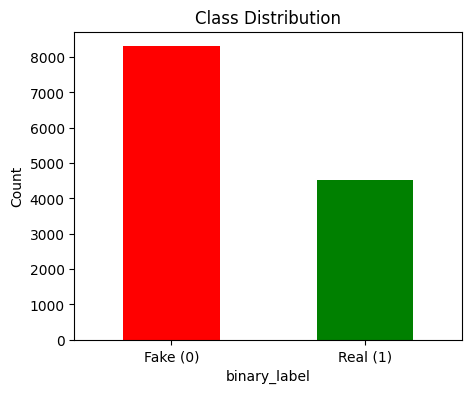

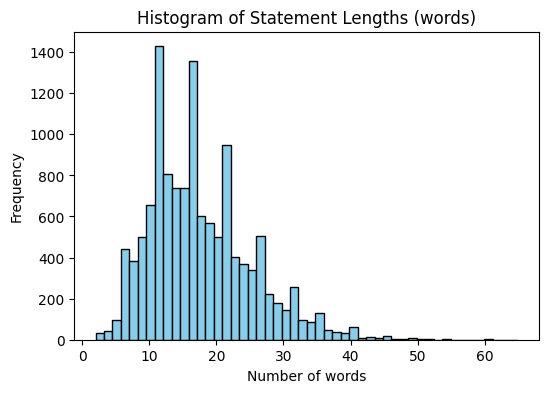

C:\Users\kanaa\AppData\Local\Temp\ipykernel_34440\1464744671.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='binary_label', y='length', data=data, palette=['red','green'])


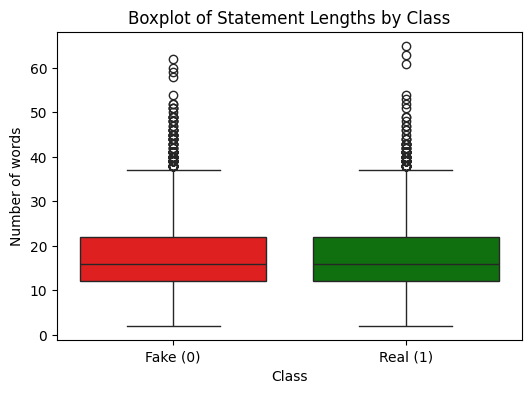

C:\Users\kanaa\AppData\Local\Temp\ipykernel_34440\1464744671.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='binary_label', y='length', data=data, palette=['red','green'])


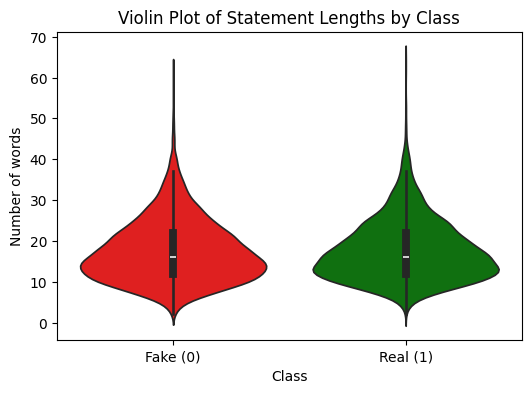

C:\Users\kanaa\AppData\Local\Temp\ipykernel_34440\1464744671.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


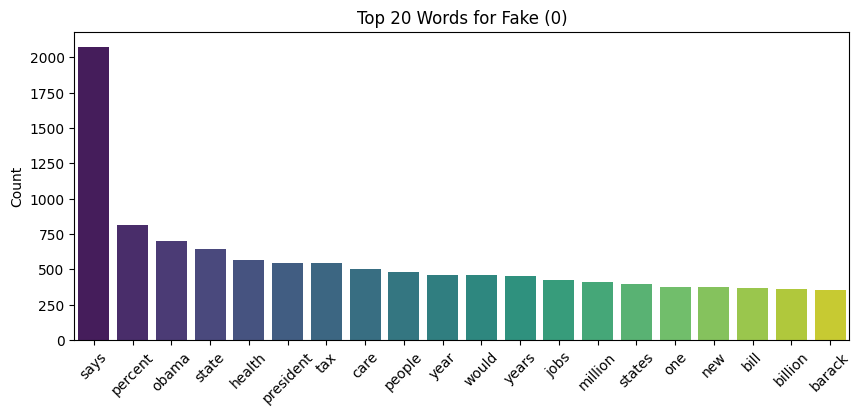

C:\Users\kanaa\AppData\Local\Temp\ipykernel_34440\1464744671.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


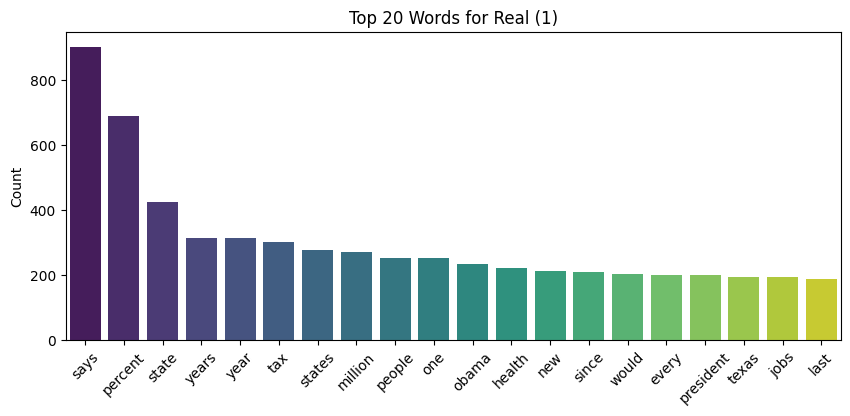

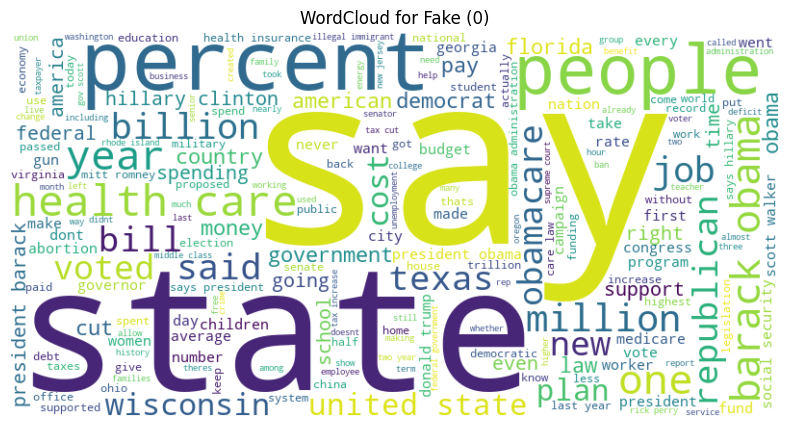

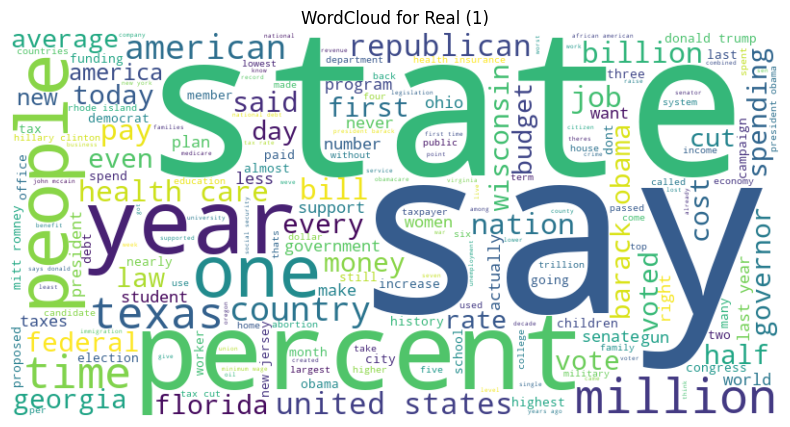

In [66]:
# load processed data
DATA_FILE = "liar_dataset\\liar_processed.csv"
data = pd.read_csv(DATA_FILE)
print("Loaded:", data.shape)

# 1. Class distribution 
plt.figure(figsize=(5,4))
data['binary_label'].value_counts().plot(kind='bar', color=['red','green'])
plt.xticks([0,1], ['Fake (0)', 'Real (1)'], rotation=0)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

# 2. Histogram of statement lengths 
data['length'] = data['clean'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
plt.hist(data['length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Statement Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# 3. Boxplot of statement lengths by class
import seaborn as sns
plt.figure(figsize=(6,4))
sns.boxplot(x='binary_label', y='length', data=data, palette=['red','green'])
plt.xticks([0,1], ['Fake (0)', 'Real (1)'])
plt.title("Boxplot of Statement Lengths by Class")
plt.xlabel("Class")
plt.ylabel("Number of words")
plt.show()

# 4. Violin plot of statement lengths by class
plt.figure(figsize=(6,4))
sns.violinplot(x='binary_label', y='length', data=data, palette=['red','green'])
plt.xticks([0,1], ['Fake (0)', 'Real (1)'])
plt.title("Violin Plot of Statement Lengths by Class")
plt.xlabel("Class")
plt.ylabel("Number of words")
plt.show()

# 5. Top 20 words per class (barplot)
from collections import Counter
for label, subset in data.groupby('binary_label'):
    text_all = " ".join(subset['no_stop'].dropna())
    label_name = "Real (1)" if label==1 else "Fake (0)"
    tokens = text_all.split()
    counter = Counter(tokens)
    common = counter.most_common(20)
    words, counts = zip(*common)
    plt.figure(figsize=(10,4))
    sns.barplot(x=list(words), y=list(counts), palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f"Top 20 Words for {label_name}")
    plt.ylabel("Count")
    plt.show()

# 6. WordClouds (if available)
for label, subset in data.groupby('binary_label'):
    text_all = " ".join(subset['no_stop'].dropna())
    label_name = "Real (1)" if label==1 else "Fake (0)"
    if WORDCLOUD_AVAILABLE:
        wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"WordCloud for {label_name}")
        plt.show()


## Step 4: Feature Engineering.

***Goals:***

1) Bag of words
2) N-grams
3) TF-IDF vectorization

## Step 5 - Model Training

***Goals:***

1) Logistic Regression
2) SVM
3) Decision Tree


=== Bag of Words + Logistic Regression (with tuning) ===
Best Params: {'C': 0.1}
Accuracy:  0.600
Precision: 0.446
Recall:    0.552
F1-score:  0.493

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1662
           1       0.45      0.55      0.49       906

    accuracy                           0.60      2568
   macro avg       0.58      0.59      0.58      2568
weighted avg       0.62      0.60      0.61      2568

Best Params: {'C': 0.1}
Accuracy:  0.600
Precision: 0.446
Recall:    0.552
F1-score:  0.493

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1662
           1       0.45      0.55      0.49       906

    accuracy                           0.60      2568
   macro avg       0.58      0.59      0.58      2568
weighted avg       0.62      0.60      0.61      2568



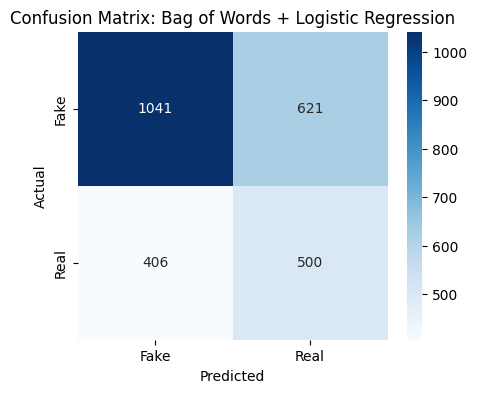


=== Bag of Words + SVM (with tuning) ===
Best Params: {'C': 0.1}
Accuracy:  0.596
Precision: 0.439
Recall:    0.526
F1-score:  0.479

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67      1662
           1       0.44      0.53      0.48       906

    accuracy                           0.60      2568
   macro avg       0.57      0.58      0.57      2568
weighted avg       0.61      0.60      0.60      2568

Best Params: {'C': 0.1}
Accuracy:  0.596
Precision: 0.439
Recall:    0.526
F1-score:  0.479

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67      1662
           1       0.44      0.53      0.48       906

    accuracy                           0.60      2568
   macro avg       0.57      0.58      0.57      2568
weighted avg       0.61      0.60      0.60      2568



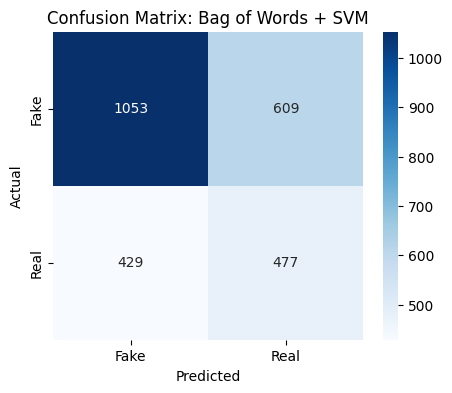


=== Bag of Words + Decision Tree (with tuning) ===
Best Params: {'max_depth': None}
Accuracy:  0.581
Precision: 0.415
Recall:    0.461
F1-score:  0.437

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67      1662
           1       0.42      0.46      0.44       906

    accuracy                           0.58      2568
   macro avg       0.55      0.55      0.55      2568
weighted avg       0.59      0.58      0.59      2568

Best Params: {'max_depth': None}
Accuracy:  0.581
Precision: 0.415
Recall:    0.461
F1-score:  0.437

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67      1662
           1       0.42      0.46      0.44       906

    accuracy                           0.58      2568
   macro avg       0.55      0.55      0.55      2568
weighted avg       0.59      0.58      0.59      2568



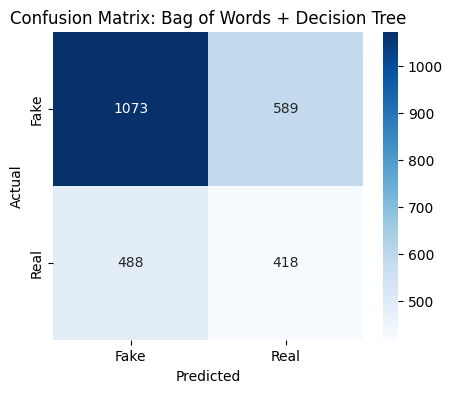


=== N-Grams + Logistic Regression (with tuning) ===
Best Params: {'C': 0.1}
Accuracy:  0.616
Precision: 0.460
Recall:    0.508
F1-score:  0.483

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.69      1662
           1       0.46      0.51      0.48       906

    accuracy                           0.62      2568
   macro avg       0.59      0.59      0.59      2568
weighted avg       0.63      0.62      0.62      2568

Best Params: {'C': 0.1}
Accuracy:  0.616
Precision: 0.460
Recall:    0.508
F1-score:  0.483

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.69      1662
           1       0.46      0.51      0.48       906

    accuracy                           0.62      2568
   macro avg       0.59      0.59      0.59      2568
weighted avg       0.63      0.62      0.62      2568



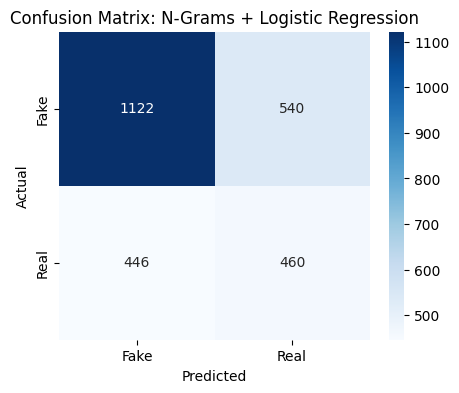


=== N-Grams + SVM (with tuning) ===
Best Params: {'C': 0.1}
Accuracy:  0.617
Precision: 0.453
Recall:    0.418
F1-score:  0.435

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71      1662
           1       0.45      0.42      0.44       906

    accuracy                           0.62      2568
   macro avg       0.57      0.57      0.57      2568
weighted avg       0.61      0.62      0.61      2568

Best Params: {'C': 0.1}
Accuracy:  0.617
Precision: 0.453
Recall:    0.418
F1-score:  0.435

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.73      0.71      1662
           1       0.45      0.42      0.44       906

    accuracy                           0.62      2568
   macro avg       0.57      0.57      0.57      2568
weighted avg       0.61      0.62      0.61      2568



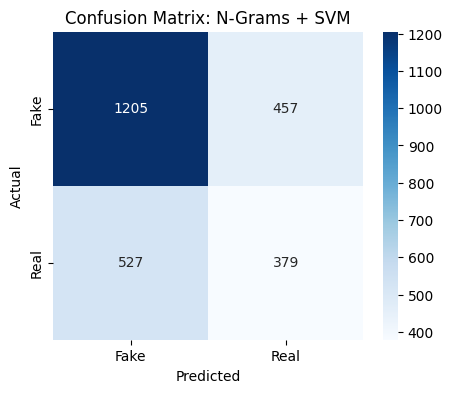


=== N-Grams + Decision Tree (with tuning) ===
Best Params: {'max_depth': None}
Accuracy:  0.585
Precision: 0.424
Recall:    0.493
F1-score:  0.456

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.63      0.66      1662
           1       0.42      0.49      0.46       906

    accuracy                           0.58      2568
   macro avg       0.56      0.56      0.56      2568
weighted avg       0.60      0.58      0.59      2568

Best Params: {'max_depth': None}
Accuracy:  0.585
Precision: 0.424
Recall:    0.493
F1-score:  0.456

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.63      0.66      1662
           1       0.42      0.49      0.46       906

    accuracy                           0.58      2568
   macro avg       0.56      0.56      0.56      2568
weighted avg       0.60      0.58      0.59      2568



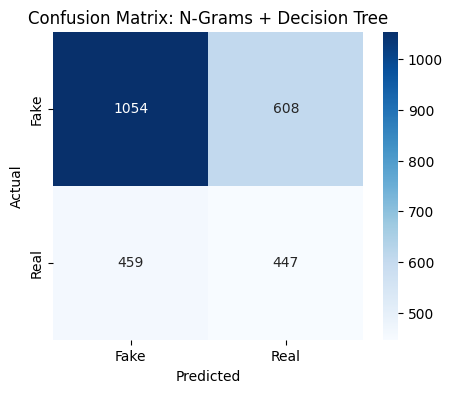


=== TF-IDF + Logistic Regression (with tuning) ===
Best Params: {'C': 0.1}
Accuracy:  0.605
Precision: 0.451
Recall:    0.554
F1-score:  0.497

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1662
           1       0.45      0.55      0.50       906

    accuracy                           0.60      2568
   macro avg       0.59      0.59      0.59      2568
weighted avg       0.63      0.60      0.61      2568



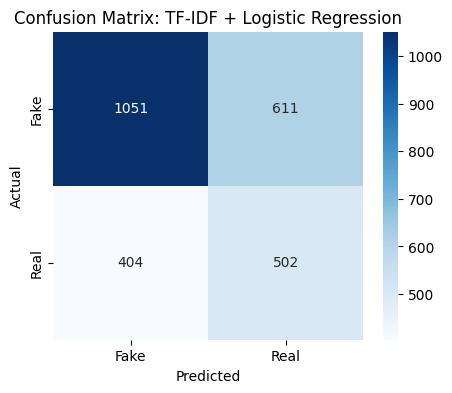


=== TF-IDF + SVM (with tuning) ===
Best Params: {'C': 0.1}
Accuracy:  0.600
Precision: 0.445
Recall:    0.538
F1-score:  0.487

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1662
           1       0.45      0.54      0.49       906

    accuracy                           0.60      2568
   macro avg       0.58      0.59      0.58      2568
weighted avg       0.62      0.60      0.61      2568

Best Params: {'C': 0.1}
Accuracy:  0.600
Precision: 0.445
Recall:    0.538
F1-score:  0.487

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1662
           1       0.45      0.54      0.49       906

    accuracy                           0.60      2568
   macro avg       0.58      0.59      0.58      2568
weighted avg       0.62      0.60      0.61      2568



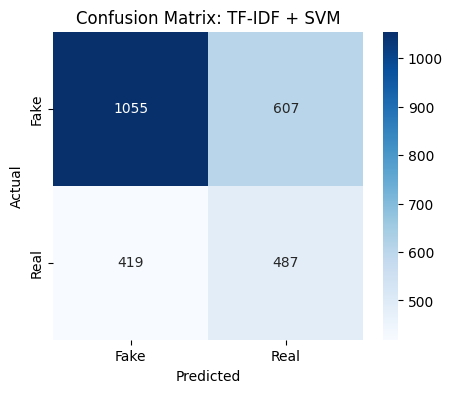


=== TF-IDF + Decision Tree (with tuning) ===
Best Params: {'max_depth': 10}
Accuracy:  0.618
Precision: 0.414
Recall:    0.196
F1-score:  0.266

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.85      0.74      1662
           1       0.41      0.20      0.27       906

    accuracy                           0.62      2568
   macro avg       0.54      0.52      0.50      2568
weighted avg       0.57      0.62      0.57      2568

Best Params: {'max_depth': 10}
Accuracy:  0.618
Precision: 0.414
Recall:    0.196
F1-score:  0.266

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.85      0.74      1662
           1       0.41      0.20      0.27       906

    accuracy                           0.62      2568
   macro avg       0.54      0.52      0.50      2568
weighted avg       0.57      0.62      0.57      2568



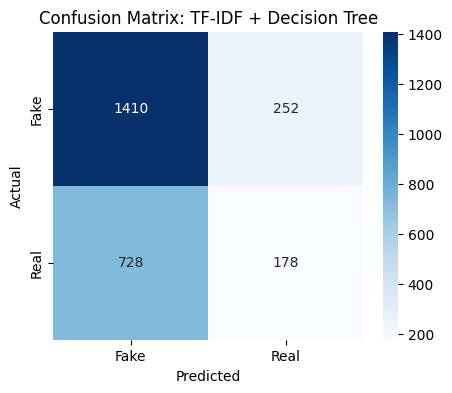


=== Summary of all models ===
     Feature               Model         Best Params  Accuracy  Precision   Recall       F1
      TF-IDF Logistic Regression          {'C': 0.1}  0.604751   0.451033 0.554084 0.497276
Bag of Words Logistic Regression          {'C': 0.1}  0.600078   0.446030 0.551876 0.493340
      TF-IDF                 SVM          {'C': 0.1}  0.600467   0.445155 0.537528 0.487000
     N-Grams Logistic Regression          {'C': 0.1}  0.616044   0.460000 0.507726 0.482686
Bag of Words                 SVM          {'C': 0.1}  0.595794   0.439227 0.526490 0.478916
     N-Grams       Decision Tree {'max_depth': None}  0.584502   0.423697 0.493377 0.455890
Bag of Words       Decision Tree {'max_depth': None}  0.580607   0.415094 0.461369 0.437010
     N-Grams                 SVM          {'C': 0.1}  0.616822   0.453349 0.418322 0.435132
      TF-IDF       Decision Tree   {'max_depth': 10}  0.618380   0.413953 0.196468 0.266467

Saved best model: Logistic Regression with TF-ID

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

# --- Feature Extraction Functions ---
def extract_features(data, method="bow", ngram_range=(1,1)):
    if method == "bow":
        vectorizer = CountVectorizer(ngram_range=ngram_range)
    elif method == "ngram":
        vectorizer = CountVectorizer(ngram_range=ngram_range)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    else:
        raise ValueError("Unknown method")
    X = vectorizer.fit_transform(data)
    return X, vectorizer

# --- Model Training & Evaluation Function ---
def train_and_evaluate(X_train, X_test, y_train, y_test, model, param_grid, model_name, feat_name):
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    print(f"Best Params: {grid.best_params_}")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print("\nClassification Report:\n", classification_report(y_test, preds, zero_division=0))
    # Plot confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {feat_name} + {model_name}')
    plt.show()
    return {
        "Feature": feat_name,
        "Model": model_name,
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ModelObj": best_model
    }

# Load features
features = joblib.load("liar_dataset\\features.pkl")
X_train_bow, X_test_bow, bow_vectorizer = features['bow']
X_train_ngram, X_test_ngram, ngram_vectorizer = features['ngram']
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = features['tfidf']
y_train, y_test = features['y_train'], features['y_test']

feature_sets = {
    "Bag of Words": (X_train_bow, X_test_bow),
    "N-Grams": (X_train_ngram, X_test_ngram),
    "TF-IDF": (X_train_tfidf, X_test_tfidf)
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver="liblinear", class_weight='balanced', random_state=42),
    "SVM": LinearSVC(class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "SVM": {"C": [0.1, 1, 10]},
    "Decision Tree": {"max_depth": [None, 10, 20]}
}

results = []

for feat_name, (Xtr, Xte) in feature_sets.items():
    for model_name, model in models.items():
        print(f"\n=== {feat_name} + {model_name} (with tuning) ===")
        res = train_and_evaluate(Xtr, Xte, y_train, y_test, model, param_grids[model_name], model_name, feat_name)
        results.append(res)

# Summary table
results_df = pd.DataFrame(results).drop(columns=["ModelObj"])
print("\n=== Summary of all models ===")
print(results_df.sort_values(by="F1", ascending=False).to_string(index=False))

# Save results to CSV
results_df.to_csv("liar_dataset\\model_results.csv", index=False)

# Save best model
best_row = results_df.sort_values(by="F1", ascending=False).iloc[0]
best_feat = best_row["Feature"]
best_model_name = best_row["Model"]
best_model_obj = [r["ModelObj"] for r in results if r["Feature"]==best_feat and r["Model"]==best_model_name][0]

# Re-train best model on full training data
best_X_train, best_X_test = feature_sets[best_feat]
best_model_obj.fit(best_X_train, y_train)

joblib.dump((best_model_obj, best_feat), "liar_dataset\\best_model.pkl")
print(f"\nSaved best model: {best_model_name} with {best_feat} to liar_dataset\\best_model.pkl")


# Observations **&** Analysis

## Compare models per feature

**Bag of Words:**

- Logistic Regression: F1 = 0.493
- SVM: F1 = 0.479
- Decision Tree: F1 = 0.437

**TF-IDF:**

- Logistic Regression: F1 = 0.497 (Best overall)
- SVM: F1 = 0.487
- Decision Tree: F1 = 0.266 (lowest)

**N-Grams:**

- Logistic Regression: F1 = 0.483
- SVM: F1 = 0.435
- Decision Tree: F1 = 0.456

---

## Compare features per model

**Logistic Regression:**
- Best: TF-IDF (0.497)
- N-Grams: 0.483
- Bag of Words: 0.493

**SVM:**
- Best: TF-IDF (0.487)
- Bag of Words: 0.479
- N-Grams: 0.435

**Decision Tree:**
- Best: N-Grams (0.456)
- Bag of Words: 0.437
- TF-IDF: 0.266

---

## Conclusions

**Overall best combination:**

- `TF-IDF + Logistic Regression → F1 = 0.497`

**Key Points:**
- Logistic Regression with TF-IDF features gives the best F1 score.
- SVM and Logistic Regression perform similarly, but SVM is slightly behind for all features.
- Decision Tree performs worst overall, especially with TF-IDF features.
- N-Grams do not outperform Bag of Words or TF-IDF for any model, but Decision Tree benefits most from N-Grams.
- All models perform better with lower C (stronger regularization).

**Takeaways:**
- For this dataset, TF-IDF features with Logistic Regression are optimal.
- SVM is a strong alternative, but slightly less effective.
- Decision Trees are not well-suited for this high-dimensional, sparse text data.
- Regularization is important for both Logistic Regression and SVM.
